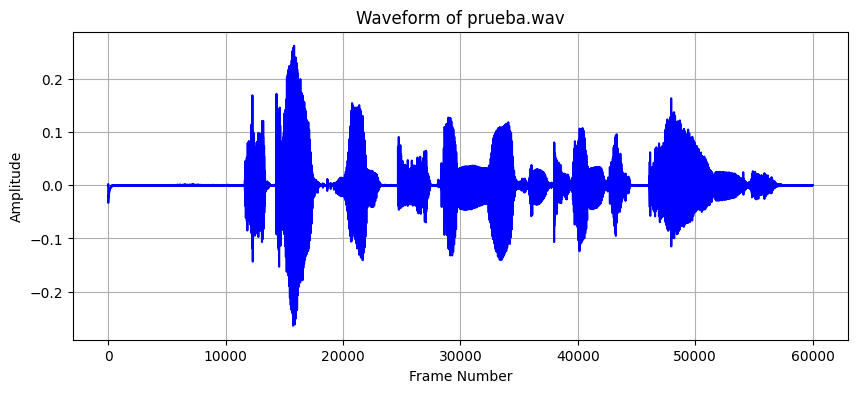

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

filename = "../../prueba.wav"
audio_data, sample_rate = sf.read(filename)

frame_numbers = np.arange(len(audio_data))

plt.figure(figsize=(10, 4))
plt.plot(frame_numbers, audio_data, color='b')
plt.title('Waveform of prueba.wav')
plt.xlabel('Frame Number')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

600


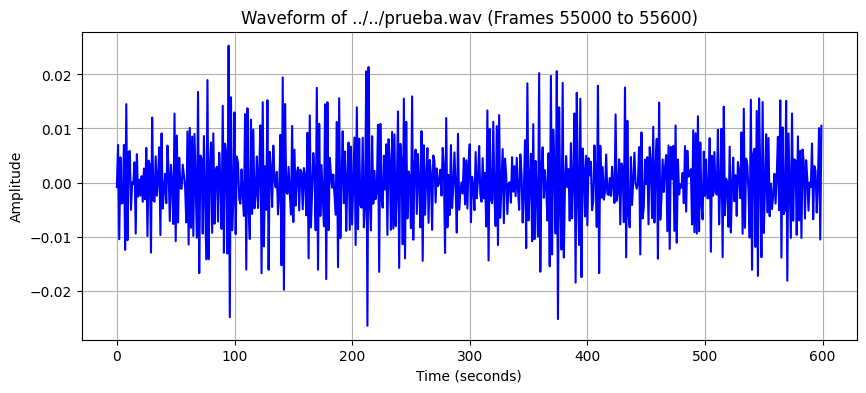

In [2]:
frame_length_ms = 30
frame_length_samples = int(frame_length_ms * sample_rate / 1000)
print(frame_length_samples)
start_frame = 55000
end_frame = start_frame + frame_length_samples

start_index = start_frame
end_index = min(end_frame, len(audio_data))

audio_data_frame = audio_data[start_index:end_index]

plt.figure(figsize=(10, 4))
plt.plot(audio_data_frame, color='b')
plt.title('Waveform of {} (Frames {} to {})'.format(filename, start_frame, end_frame))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

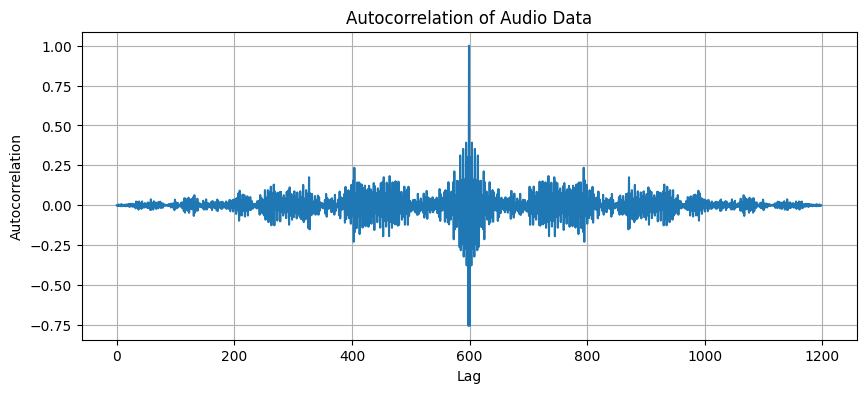

In [3]:
autocorr = np.correlate(audio_data_frame, audio_data_frame, mode='full')

autocorr /= np.max(autocorr)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Audio Data')
plt.grid(True)
plt.show()

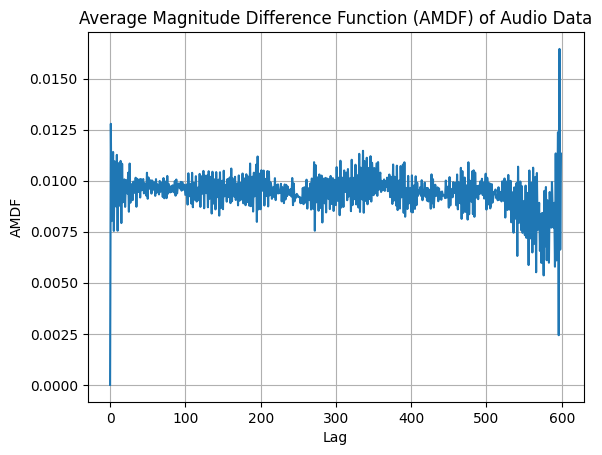

In [4]:
def compute_amdf(signal):
    N = len(signal)
    amdf = np.zeros(N)  

    for lag in range(1, N):
        amdf[lag] = np.mean(np.abs(signal[:-lag] - signal[lag:]))
        
    return amdf

amdf = compute_amdf(audio_data_frame)

plt.plot(amdf)
plt.xlabel('Lag')
plt.ylabel('AMDF')
plt.title('Average Magnitude Difference Function (AMDF) of Audio Data')
plt.grid(True)
plt.show()